<a href="https://colab.research.google.com/github/jhodgens17/audio_classification/blob/main/Enhanced_Model_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import packages
import os.path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython import display

The objective of this capstone project is to leverage the TensorFlow Speech Commands Dataset in order to build a speech recognition model to better understand the technology behind speech-based virtual assistants. This notebook contains the code for devloping a neural network model used to make predictions on the Kaggle Speech Recognition Challenge dataset.

# **Data Understanding**

The dataset used in this capstone project was obtained via a Kaggle competition from 2018. At that time, Tensorflow released this speech commands dataset in order to enable developers to program their own speech recognition algorithims. It contains ~65,000 1 second long audio clips of different people speaking 30 different words. The objective of the Kaggle competition was to program a speech recogntion model that identifies a subset of 10 of these words.


In [2]:
#This list includes the 10 target words of interest
target_words = ['down', 'go', 'left', 'no', 'off',
           'on', 'right', 'stop', 'up', 'yes']

In [3]:
#This list includes the other words included in the dataset
unknown = ['bed', 'bird', 'cat', 'dog', 'eight', 
           'five', 'four', 'happy', 'house', 'marvin',
           'nine', 'one', 'seven', 'sheila', 'six', 'three',
           'tree', 'two', 'wow', 'zero']

In [4]:
all_words = target_words + unknown

In [5]:
#Get a dictionary of the file names
files = {}
for word in all_words:
  path = '/content/drive/MyDrive/train/audio/'+word
  file_list = os.listdir(path)
  files[word] = file_list

In [6]:
#Checking the size of the dictionary
len(files)

30

In [7]:
#Checking the number of files for each word
for word in files:
  print(len(files[word]))

2359
2372
2353
2375
2357
2367
2367
2380
2375
2377
1713
1731
1733
1746
2352
2357
2372
1742
1750
1746
2364
2370
2377
1734
2369
2356
1733
2373
1745
2376


In [8]:
#Checking the total number of files
total = 0
for word in files:
  total = total + len(files[word])
total

64721

In [9]:
#Getting the file path for each audio clip
paths = {}
for word in files:
  path_list = []
  for file in files[word]:
    path = '/content/drive/MyDrive/train/audio/' + word + '/' + file
    path_list.append(path)
  paths[word] = path_list

In [10]:
#Checking size of the new dictionary
len(paths)

30

In [11]:
#Checking the number of paths
total_paths = 0
for word in paths:
  total_paths = total_paths + len(paths[word])
total_paths

64721

In [12]:
#Getting lists of paths and targets (spoken word)
word_list = []
path_list = []
for target in files:
  if target in target_words:
    for file in files[target]:
      path = '/content/drive/MyDrive/train/audio/' + target + '/' + file
      path_list.append(path)
      word_list.append(target)
  else:
    for file in files[target]:
      path = '/content/drive/MyDrive/train/audio/' + target + '/' + file
      path_list.append(path)
      word_list.append('unknown')

In [13]:
#Checking length of word list
len(word_list)

64721

In [14]:
#Checking length of path list
len(path_list)

64721

In [15]:
#Adding files for silence (audio clips that do not include any words)
silent_names = ['bike', 'dish', 'dude', 'pink', 'tap', 'white']
silent_paths = []
for word in silent_names:
  path = '/content/drive/MyDrive/silence/'+word
  file_list = os.listdir(path)
  for file in file_list:
    full_path = '/content/drive/MyDrive/silence/'+word+'/'+file
    silent_paths.append(full_path)

In [16]:
#Checking length of this list
len(silent_paths)

396

In [17]:
#Creating a list for the targets for these silent clips
silent_targets = ['silence']*396

In [18]:
#Appending the lists
all_paths = path_list + silent_paths

In [19]:
all_targets = word_list + silent_targets

# Data Preparation



TensorFlow contains functions that can process these audio files into a format that can be used to train a speech detection model.

In [20]:
#Creating a dataset for all of the files
files_ds = tf.data.Dataset.from_tensor_slices(all_paths)

In [21]:
#Defining function to get waveform for each audio clip
def get_waveform(path):
  audio_binary = tf.io.read_file(path)
  audio, sample_rate = tf.audio.decode_wav(audio_binary)
  waveform = tf.squeeze(audio, axis=-1)
  return waveform

In [22]:
#Demonstrting the waveform funciton on one example
waveform = get_waveform(path_list[1717])
waveform

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([0.00042725, 0.00033569, 0.00018311, ..., 0.00054932, 0.00079346,
       0.0010376 ], dtype=float32)>

In [23]:
path_list[1717]

'/content/drive/MyDrive/train/audio/down/afbec28d_nohash_0.wav'

In [24]:
word_list[1717]

'down'

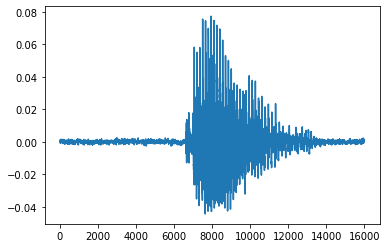

In [25]:
#The waveform can be plotted visually
plt.plot(waveform)

The waveform represents the amplitude of a sound wave (i.e. the strength of the audio) over a period of time. Each of the audio clips contained in this dataset have a sampling rate of 16,000 Hz, which means that the audio file contains 16,000 data points per second. Therefore, when we process the clips into their waveforms, we are representing them as tensors of 16,000 numbers (most clips are 1-sec long; however, there were a few that were shorter). The next step is to process the waveform to a spectrogram.

In [26]:
#Defining a function that makes all audio clips same length and gets spectrogram
def get_spectrogram(waveform):
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  return spectrogram

In [27]:
#Demonstrting the spectrogram funciton on one example
spectrogram = get_spectrogram(waveform)
spectrogram_abs = tf.abs(spectrogram)
spectrogram

<tf.Tensor: shape=(124, 129), dtype=float32, numpy=
array([[2.6857503e-02, 1.5097800e-02, 2.3011047e-02, ..., 9.9685727e-05,
        5.9804792e-05, 4.5689754e-05],
       [9.5076859e-03, 2.0525515e-02, 4.1951492e-02, ..., 1.1229752e-04,
        5.7147874e-05, 3.0147377e-05],
       [7.5083254e-03, 1.1578057e-02, 2.1956393e-02, ..., 6.5327156e-05,
        4.6946800e-05, 2.1033920e-05],
       ...,
       [2.0974565e-02, 8.2993098e-03, 4.2936292e-02, ..., 1.1753873e-04,
        9.6370335e-05, 3.3983029e-05],
       [6.4048395e-03, 2.3303296e-02, 2.9184328e-02, ..., 5.6688838e-05,
        7.8216653e-05, 6.7941612e-05],
       [5.0217561e-02, 4.5906417e-02, 3.7272256e-02, ..., 1.4609029e-04,
        9.7764372e-05, 1.7745979e-04]], dtype=float32)>

In [28]:
#Defining a function to plot the spectrogram
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

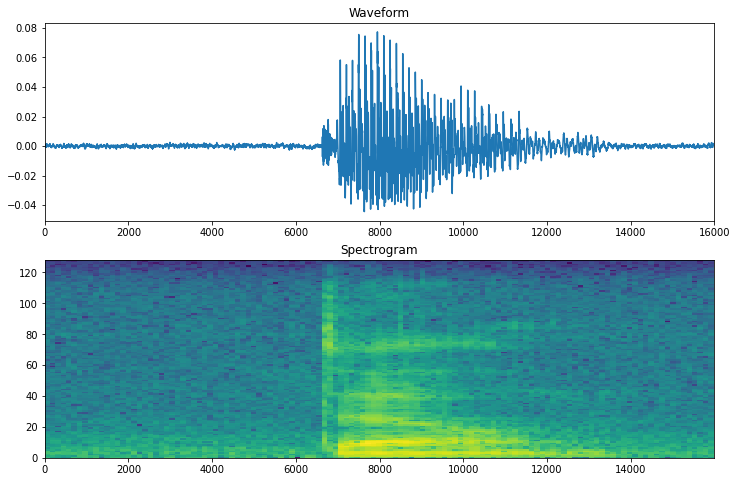

In [29]:
#Plotting the waveform and spectrogram together
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram_abs.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

A spectrogram is a visual depiction of the changing frequency of a sound. In the above example, the brighter colors indicate a greater frequency (i.e. a higher pitched sound). The spectrogram for each audio clip will be used to train the speech detection model in the following sections. Finally, here is the audio clip of the above example.

In [30]:
display.display(display.Audio(waveform, rate=16000))

In [31]:
#Checking the label for this clip
word_list[1717]

'down'

In [32]:
#Getting the waveform for each file
waveform_ds = files_ds.map(get_waveform)

In [33]:
#Getting the spectrogram for each file
spectrogram_ds = waveform_ds.map(get_spectrogram)

# Modeling/Evaluation

In [34]:
#Getting the spectrograms as an array in order to train/test split
spec = np.stack(list(spectrogram_ds))

In [35]:
X = spec

In [36]:
X.shape

(65117, 124, 129)

In [37]:
#Getting binary targets for all 12 words
y = pd.get_dummies(all_targets)

In [38]:
#Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [39]:
#Getting the shape of the spectrogram
for spectrogram in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)

Input shape: (124, 129)


In [40]:
#Instantiate model
model = Sequential()

In [41]:
#Build model
model.add(InputLayer(input_shape=input_shape))
model.add(Conv1D(32,3, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(12))

In [42]:
#Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [43]:
#Fit model
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
764/764 [==============================] - 18s 4ms/step - loss: 0.6788 - accuracy: 0.6096
Epoch 2/10
764/764 [==============================] - 3s 4ms/step - loss: 0.3453 - accuracy: 0.6283
Epoch 3/10
764/764 [==============================] - 3s 4ms/step - loss: 0.3156 - accuracy: 0.6305
Epoch 4/10
764/764 [==============================] - 3s 4ms/step - loss: 0.3133 - accuracy: 0.6314
Epoch 5/10
764/764 [==============================] - 3s 4ms/step - loss: 0.2967 - accuracy: 0.6323
Epoch 6/10
764/764 [==============================] - 3s 4ms/step - loss: 0.2910 - accuracy: 0.6342
Epoch 7/10
764/764 [==============================] - 3s 4ms/step - loss: 0.2959 - accuracy: 0.6339
Epoch 8/10
764/764 [==============================] - 3s 4ms/step - loss: 0.2993 - accuracy: 0.6342
Epoch 9/10
764/764 [==============================] - 3s 4ms/step - loss: 0.2981 - accuracy: 0.6342
Epoch 10/10
764/764 [==============================] - 3s 4ms/step - loss: 0.2986 - accuracy: 0.636

In [44]:
#Getting predictions for test set
y_pred = np.argmax(model.predict(X_test), axis = 1)

In [45]:
#Getting the actual values of test set in order to compare to predictions
y_test_actual = y_test.idxmax(axis = 1)

In [46]:
#Creating a dictionary to update numeric values from predictions
tar_dict = {0:'down', 1:'go', 2:'left', 3:'no', 4:'off',
            5:'on', 6:'right', 7: 'silence', 8:'stop', 9: 'unknown', 10:'up', 11: 'yes'}

In [47]:
#Updating predicted values to words
y_pred_list = []
for value in y_pred:
  y_pred_list.append(tar_dict[value])
y_pred_words = np.array(y_pred_list)

In [48]:
#Getting accuracy score for test set
accuracy_score(y_test_actual, y_pred_words)

0.6197174447174447

In [49]:
#Instantiate second model
model2 = Sequential()

In [50]:
#Build second model
model2.add(InputLayer(input_shape=input_shape))
model2.add(Conv1D(32,3, activation='relu'))
model2.add(Conv1D(64,3, activation='relu'))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(12, activation='softmax'))

In [51]:
#Compile second model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
#Fit second model
model2.fit(X_train, y_train, epochs=25, batch_size=64)

Epoch 1/25
764/764 [==============================] - 4s 4ms/step - loss: 1.0526 - accuracy: 0.6985
Epoch 2/25
764/764 [==============================] - 3s 4ms/step - loss: 0.5453 - accuracy: 0.8328
Epoch 3/25
764/764 [==============================] - 3s 4ms/step - loss: 0.3860 - accuracy: 0.8796
Epoch 4/25
764/764 [==============================] - 3s 4ms/step - loss: 0.2907 - accuracy: 0.9078
Epoch 5/25
764/764 [==============================] - 3s 4ms/step - loss: 0.2430 - accuracy: 0.9233
Epoch 6/25
764/764 [==============================] - 3s 4ms/step - loss: 0.1971 - accuracy: 0.9370
Epoch 7/25
764/764 [==============================] - 3s 5ms/step - loss: 0.1754 - accuracy: 0.9460
Epoch 8/25
764/764 [==============================] - 3s 5ms/step - loss: 0.1584 - accuracy: 0.9501
Epoch 9/25
764/764 [==============================] - 3s 5ms/step - loss: 0.1213 - accuracy: 0.9621
Epoch 10/25
764/764 [==============================] - 3s 5ms/step - loss: 0.1111 - accuracy: 0.9661

In [53]:
#Getting predictions for test set
y_pred2 = np.argmax(model2.predict(X_test), axis = 1)

In [54]:
#Updating predicted values to words
y_pred2_list = []
for value in y_pred2:
  y_pred2_list.append(tar_dict[value])
y_pred2_words = np.array(y_pred2_list)

In [55]:
#Getting accuracy score for test set
accuracy_score(y_test_actual, y_pred2_words)

0.896990171990172

The second model showed significant improvement over the first. However, the discrepancy between the train and test accuracies indicates overfitting. Furthermore, the model did not perform well on the Kaggle dataset.

In [56]:
#Instantiate third model
model3 = Sequential()

In [57]:
#Build third model
model3.add(InputLayer(input_shape=input_shape))
model3.add(Conv1D(32,3, activation='relu'))
model3.add(MaxPooling1D())
model3.add(Dropout(0.3))
model3.add(Conv1D(64,3, activation='relu'))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(12, activation='softmax'))

In [58]:
#Compile third model
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
#Fit third model
model3.fit(X_train, y_train, epochs=25, batch_size=64)

Epoch 1/25
764/764 [==============================] - 4s 5ms/step - loss: 1.3362 - accuracy: 0.6398
Epoch 2/25
764/764 [==============================] - 3s 5ms/step - loss: 0.8952 - accuracy: 0.7163
Epoch 3/25
764/764 [==============================] - 3s 5ms/step - loss: 0.7005 - accuracy: 0.7762
Epoch 4/25
764/764 [==============================] - 3s 5ms/step - loss: 0.5918 - accuracy: 0.8123
Epoch 5/25
764/764 [==============================] - 4s 5ms/step - loss: 0.5231 - accuracy: 0.8359
Epoch 6/25
764/764 [==============================] - 4s 5ms/step - loss: 0.4677 - accuracy: 0.8529
Epoch 7/25
764/764 [==============================] - 4s 5ms/step - loss: 0.4392 - accuracy: 0.8623
Epoch 8/25
764/764 [==============================] - 4s 5ms/step - loss: 0.4020 - accuracy: 0.8737
Epoch 9/25
764/764 [==============================] - 4s 5ms/step - loss: 0.3832 - accuracy: 0.8804
Epoch 10/25
764/764 [==============================] - 4s 5ms/step - loss: 0.3566 - accuracy: 0.8882

In [60]:
#Getting predictions for test set
y_pred3 = np.argmax(model3.predict(X_test), axis = 1)

In [61]:
#Updating predicted values to words
y_pred3_list = []
for value in y_pred3:
  y_pred3_list.append(tar_dict[value])
y_pred3_words = np.array(y_pred3_list)

In [62]:
#Getting accuracy score for test set
accuracy_score(y_test_actual, y_pred3_words)

0.9165847665847666

This model had accuracy scores that were approximately equal for the train and test sets; however, there was still room for improvement on the kaggle set.

In [63]:
#Getting counts of each label in order to address class imbalance
y.sum()

down        2359
go          2372
left        2353
no          2375
off         2357
on          2367
right       2367
silence      396
stop        2380
unknown    41039
up          2375
yes         2377
dtype: int64

In [64]:
#Getting total number of clips
total = len(y)

In [65]:
#Getting weights for each target
weight_for_0 = (1 / 2359) * (total / 12.0)
weight_for_1 = (1 / 2372) * (total / 12.0)
weight_for_2 = (1 / 2353) * (total / 12.0)
weight_for_3 = (1 / 2375) * (total / 12.0)
weight_for_4 = (1 / 2357) * (total / 12.0)
weight_for_5 = (1 / 2367) * (total / 12.0)
weight_for_6 = (1 / 2367) * (total / 12.0)
weight_for_7 = (1 / 396) * (total / 12.0)
weight_for_8 = (1 / 2380) * (total / 12.0)
weight_for_9 = (1 / 41039) * (total / 12.0)
weight_for_10 = (1 / 2375) * (total / 12.0)
weight_for_11 = (1 / 2377) * (total / 12.0)


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3,
                4: weight_for_0, 5: weight_for_5, 6: weight_for_6,
                7: weight_for_7, 8: weight_for_8, 9: weight_for_9, 10: weight_for_10,
                11: weight_for_11}

In [66]:
#Instantiate fourth model
model4 = Sequential()

In [67]:
#Build fourth model
model4.add(InputLayer(input_shape=input_shape))
model4.add(Conv1D(32,3, activation='relu'))
model4.add(MaxPooling1D())
model4.add(Dropout(0.3))
model4.add(Conv1D(64,3, activation='relu'))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(12, activation='softmax'))

In [68]:
#Compile fourth model
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [69]:
#Fit fourth model
model4.fit(X_train, y_train, epochs=25, batch_size=64, class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25
764/764 [==============================] - 4s 5ms/step - loss: 1.9552 - accuracy: 0.2029
Epoch 2/25
764/764 [==============================] - 4s 5ms/step - loss: 1.2567 - accuracy: 0.3684
Epoch 3/25
764/764 [==============================] - 4s 5ms/step - loss: 0.9669 - accuracy: 0.4504
Epoch 4/25
764/764 [==============================] - 4s 5ms/step - loss: 0.8149 - accuracy: 0.5126
Epoch 5/25
764/764 [==============================] - 4s 5ms/step - loss: 0.7163 - accuracy: 0.5517
Epoch 6/25
764/764 [==============================] - 4s 5ms/step - loss: 0.6464 - accuracy: 0.5840
Epoch 7/25
764/764 [==============================] - 4s 5ms/step - loss: 0.5955 - accuracy: 0.6163
Epoch 8/25
764/764 [==============================] - 4s 5ms/step - loss: 0.5644 - accuracy: 0.6351
Epoch 9/25
764/764 [==============================] - 4s 5ms/s

In [70]:
#Getting predictions for test set
y_pred4 = np.argmax(model4.predict(X_test), axis = 1)

In [71]:
#Updating predicted values to words
y_pred4_list = []
for value in y_pred4:
  y_pred4_list.append(tar_dict[value])
y_pred4_words = np.array(y_pred4_list)

In [72]:
#Getting accuracy score for test set
accuracy_score(y_test_actual, y_pred4_words)

0.7544226044226044

In [73]:
#Saving the model
model4.save('/content/drive/MyDrive/V7')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/V7/assets


The fourth model had lower accuracy on the train/test sets; however, it performed the best on the Kaggle dataset with an accuracy of ~74%.